In [1]:
from lr.models.transformers.processor import NLIProcessor, features2dataset
from lr.models.transformers.processor import filter_df_by_label
from lr.models.transformers.train_functions import evaluate, train, set_seed

import logging
import os
import shutil
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from time import time
from sklearn.model_selection import train_test_split

### Params

In [2]:
folder = "snli"

hyperparams = {"local_rank": -1,
               "max_seq_length": 200,
               "overwrite_cache": False,
               "num_train_epochs":1.0,
               "per_gpu_train_batch_size":32,
               "per_gpu_eval_batch_size":32,
               "gradient_accumulation_steps": 1,
               "learning_rate":5e-5,
               "weight_decay":0.0,
               "adam_epsilon": 1e-8,
               "max_grad_norm": 1.0,
               "max_steps": 20,
               "warmup_steps": 0,
               "save_steps": 2,
               "no_cuda":False,
               "n_gpu":1,
               "model_name_or_path":"bert",
               "output_dir":"bert",
               "random_state": 42,
               "fp16":False,
               "fp16_opt_level":"01",
               "device":"cpu",
               "verbose":True,
               "model_type": "bert",
               "pad_on_left":False,
               "pad_token":0,
               "pad_token_segment_id":0,
               "mask_padding_with_zero":True,
               "base_path": "data/{}/cached_".format(folder)} 

# loading tokenizers

In [3]:
set_seed(hyperparams["random_state"], hyperparams["n_gpu"])

pretrained_weights = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained_weights)
hyperparams["tokenizer"] = tokenizer

## Set results dict

In [4]:
meta_results = {"moment":[],
                "type":[],
                "loss":[],
                "acc":[],
                "time":[]}

# df

In [5]:
train_path = "data/{}/train.csv".format(folder)
set_seed(hyperparams["random_state"], hyperparams["n_gpu"])

eval_sample_size = 100


df = pd.read_csv(train_path)
df = df.head(1000)

df_train, df_dev = train_test_split(df, test_size=0.2)
df_train_to_eval = df_train.sample(n=eval_sample_size, random_state=hyperparams["random_state"])
df_dev_to_eval = df_dev.sample(n=eval_sample_size,random_state=hyperparams["random_state"])

# assert np.all(df_train.index[:3] == [305830, 486798, 386780])

## Creating features

In [6]:
processor = NLIProcessor(hyperparams)
init = time()
train_cached_features_file = processor.df2features(df=df_train,
                                                   n_cores=8,
                                                   mode="train")

train_to_eval_cached_features_file = processor.df2features(df=df_train_to_eval,
                                                           n_cores=8,
                                                           mode="train_to_eval")

dev_cached_features_file = processor.df2features(df=df_dev,
                                                   n_cores=8,
                                                   mode="dev")

dev_to_eval_cached_features_file = processor.df2features(df=df_dev_to_eval,
                                                         n_cores=8,
                                                         mode="dev_to_eval")

p_time = time() - init
print("total time = {:.3f}".format(p_time / 60))

total time = 0.033


## Loading Datasets

In [7]:
init = time()
train_dataset = features2dataset(train_cached_features_file)
train_dataset_to_eval = features2dataset(train_to_eval_cached_features_file)
dev_dataset = features2dataset(dev_cached_features_file)
dev_dataset_to_eval = features2dataset(dev_to_eval_cached_features_file)
p_time = time() - init
print("total time = {:.3f}".format(p_time / 60))

total time = 0.000


In [8]:
print(len(train_dataset))
print(len(train_dataset_to_eval))
print(len(dev_dataset))
print(len(dev_dataset_to_eval))

798
100
200
100


## Loading Model

In [9]:
model = BertForSequenceClassification.from_pretrained(pretrained_weights, num_labels = 3)

### Eval before training

#### Train sample

In [10]:
train_loss, train_results = evaluate(train_dataset_to_eval, hyperparams, model)
train_acc = (train_results.prediction==train_results.label).mean()

lmap = processor.get_label_map()
filtered = filter_df_by_label(df_train_to_eval.dropna()).reset_index(drop=True)
assert np.all(filtered.label.map(lambda x: lmap[x]) == train_results.label)



meta_results["moment"].append("before")
meta_results["type"].append("train")
meta_results["loss"].append(train_loss)
meta_results["acc"].append(train_acc)
meta_results["time"].append(np.nan)

Evaluating: 100%|██████████| 4/4 [00:12<00:00,  3.03s/it]


#### Dev sample

In [11]:
dev_loss, results = evaluate(dev_dataset_to_eval, hyperparams, model)
dev_acc = (results.prediction==results.label).mean()


filtered = filter_df_by_label(df_dev_to_eval.dropna()).reset_index(drop=True)
assert np.all(filtered.label.map(lambda x: lmap[x]) == results.label)



meta_results["moment"].append("before")
meta_results["type"].append("dev")
meta_results["loss"].append(dev_loss)
meta_results["acc"].append(dev_acc)
meta_results["time"].append(np.nan)

Evaluating: 100%|██████████| 4/4 [00:12<00:00,  3.05s/it]


# Train

In [12]:
init = time()
global_step, tr_loss = train(train_dataset,
                             train_dataset_to_eval,
                             dev_dataset_to_eval,
                             model, tokenizer, hyperparams)
train_time = time() - init

Iteration:   4%|▍         | 1/25 [00:12<04:59, 12.46s/it]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 1/4 [00:03<00:11,  3.69s/it]

Evaluating:  50%|█████     | 2/4 [00:07<00:07,  3.71s/it]

Evaluating:  75%|███████▌  | 3/4 [00:11<00:03,  3.72s/it]

Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.91s/it]


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 1/4 [00:03<00:11,  3.75s/it]

Evaluating:  50%|█████     | 2/4 [00:07<00:07,  3.75s/it]

Evaluating:  75%|███████▌  | 3/4 [00:11<00:03,  3.75s/it]

Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.93s/it]

Iteration:  12%|█▏        | 3/25 [01:01<06:24, 17.46s/it]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:  25%|██▌       | 1/4 [00:03<00:11,  3.70s/it]

Evaluating:  50%|█████     | 2/4 [00:07<00:07,  3.72s/it]

Evaluating:  75%|███████▌  | 3/4 [00:11<00:03,  3.73s/it]

Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.92s/it]


Evaluating:   0%|  

### Eval after training

#### Train sample

In [13]:
train_loss, train_results = evaluate(train_dataset_to_eval, hyperparams, model)
train_acc = (train_results.prediction==train_results.label).mean()

filtered = filter_df_by_label(df_train_to_eval.dropna()).reset_index(drop=True)
assert np.all(filtered.label.map(lambda x: lmap[x]) == train_results.label)



meta_results["moment"].append("after")
meta_results["type"].append("train")
meta_results["loss"].append(train_loss)
meta_results["acc"].append(train_acc)
meta_results["time"].append(train_time)

Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.96s/it]


#### Dev sample

In [14]:
dev_loss, results = evaluate(dev_dataset_to_eval, hyperparams, model)
dev_acc = (results.prediction==results.label).mean()


filtered = filter_df_by_label(df_dev_to_eval.dropna()).reset_index(drop=True)
assert np.all(filtered.label.map(lambda x: lmap[x]) == results.label)



meta_results["moment"].append("after")
meta_results["type"].append("dev")
meta_results["loss"].append(dev_loss)
meta_results["acc"].append(dev_acc)
meta_results["time"].append(train_time)

Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.93s/it]


## Results

In [15]:
meta_results = pd.DataFrame(meta_results)
meta_results.to_csv("meta.csv",index=False)
meta_results

,moment,type,loss,acc,time
0,before,train,1.304386,0.33,NaN
1,before,dev,1.167507,0.36,NaN
2,after,train,1.085443,0.41,499.999792
3,after,dev,1.027093,0.44,499.999792


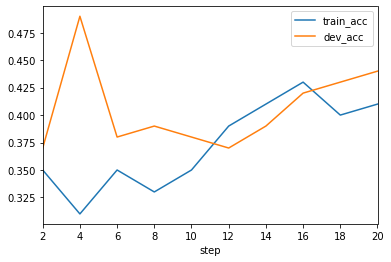

In [21]:
df_eval = pd.read_csv("bert/eval_log.csv")
df_eval.set_index(["step"])[["train_acc","dev_acc"]].plot();

### loading models

In [30]:
s = 'bert/checkpoint-2/'
model = BertForSequenceClassification.from_pretrained(s)

dev_loss, results = evaluate(dev_dataset_to_eval, hyperparams, model)
dev_acc = (results.prediction==results.label).mean()
print(dev_acc )

Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.89s/it]

0.37


In [31]:
s = 'bert/checkpoint-18/'
model = BertForSequenceClassification.from_pretrained(s)

dev_loss, results = evaluate(dev_dataset_to_eval, hyperparams, model)
dev_acc = (results.prediction==results.label).mean()
print(dev_acc )

Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.89s/it]

0.43
